<a href="https://colab.research.google.com/github/hernss/MachineLearningCourse/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling Up


## Creating helper functions


In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py



--2023-02-21 23:00:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-21 23:00:52 (75.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data, walk_through_dir

## Download data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2023-02-21 23:00:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  38.0MB/s    in 40s     

2023-02-21 23:01:37 (39.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
train_dir = "/content/101_food_classes_10_percent/train/"
test_dir = "/content/101_food_classes_10_percent/test/"

In [5]:
# How many images/classes are there?
walk_through_dir("/content/101_food_classes_10_percent/")

There are 2 directories and 0 images in '/content/101_food_classes_10_percent/'.
There are 101 directories and 0 images in '/content/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '/content/101_food_classes_10_percent/test/crab_cakes'.
There are 0 directories and 250 images in '/content/101

## Set up data inputs

In [6]:
import tensorflow as tf
IMG_SIZE=(224,224)

print("Train data")
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical")

print("Test Data")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False)

Train data
Found 7575 files belonging to 101 classes.
Test Data
Found 25250 files belonging to 101 classes.


# Train a bid dog model with transfer learning on 10% if 101 food classes

* Create a ModelCheckpoint callback
* Create a data augmentation layer 
* Build a headless Functional EfficientNetB0 Model
* Compile our model
* Feature extraction for 5 epochs (validation with 15% of data)

## Create a checkpoint callback


In [7]:
checkpoint_path = "101_clases_10_percent_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy")

## Create data augmentation layer

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1./255), # Not necesary for EfficientNetB0
], name="data_augmentation")

In [9]:
# Set yp the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Set up model architecture
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_pooling")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

# Create a model
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [10]:
# Get model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pooling (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_0 = model.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[checkpoint_callback])
            

Epoch 1/5


237/237 [==============================] - 137s 501ms/step - loss: 3.3629 - accuracy: 0.2706 - val_loss: 2.5219 - val_accuracy: 0.4473
Epoch 2/5
237/237 [==============================] - 102s 429ms/step - loss: 2.1924 - accuracy: 0.4964 - val_loss: 2.0489 - val_accuracy: 0.5132
Epoch 3/5
237/237 [==============================] - 96s 401ms/step - loss: 1.8254 - accuracy: 0.5641 - val_loss: 1.9002 - val_accuracy: 0.5315
Epoch 4/5
237/237 [==============================] - 92s 387ms/step - loss: 1.5963 - accuracy: 0.6128 - val_loss: 1.8308 - val_accuracy: 0.5336
Epoch 5/5
237/237 [==============================] - 90s 379ms/step - loss: 1.4395 - accuracy: 0.6463 - val_loss: 1.7636 - val_accuracy: 0.5408


In [12]:
model.evaluate(test_data)

790/790 [==============================] - 68s 86ms/step - loss: 1.5726 - accuracy: 0.5875


[1.5725524425506592, 0.587485134601593]

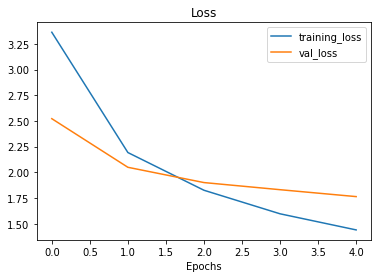

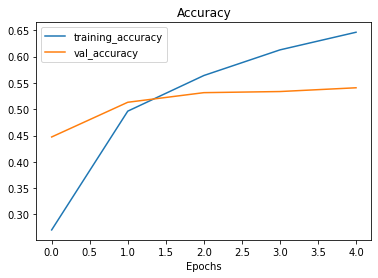

In [13]:
plot_loss_curves(history_0)

# Fine tuning

In [14]:
# Unfreeze all layers
base_model.trainable = True 

# Refreeze all layers except last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [15]:
print("Complete model layers:")
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name, layer.trainable)

print("\nBase model layers:")
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

Complete model layers:
0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_pooling True
4 output_layer True

Base model layers:
0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_ex

In [16]:
# Decrease learning rate, recompile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# load weights from checkpoint
#model.load_weights(checkpoint_path)


In [17]:
history_1 = model.fit(train_data,
                      epochs=10,
                      initial_epoch=history_0.epoch[-1],
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)))

Epoch 5/10


237/237 [==============================] - 105s 381ms/step - loss: 1.1977 - accuracy: 0.6906 - val_loss: 1.7114 - val_accuracy: 0.5535
Epoch 6/10
237/237 [==============================] - 83s 348ms/step - loss: 1.0782 - accuracy: 0.7172 - val_loss: 1.7266 - val_accuracy: 0.5548
Epoch 7/10
237/237 [==============================] - 84s 353ms/step - loss: 1.0093 - accuracy: 0.7281 - val_loss: 1.6847 - val_accuracy: 0.5633
Epoch 8/10
237/237 [==============================] - 81s 340ms/step - loss: 0.9476 - accuracy: 0.7452 - val_loss: 1.6894 - val_accuracy: 0.5604
Epoch 9/10
237/237 [==============================] - 80s 337ms/step - loss: 0.8878 - accuracy: 0.7582 - val_loss: 1.7120 - val_accuracy: 0.5572
Epoch 10/10
237/237 [==============================] - 79s 328ms/step - loss: 0.8509 - accuracy: 0.7684 - val_loss: 1.7559 - val_accuracy: 0.5479


In [18]:
model.evaluate(test_data)

790/790 [==============================] - 67s 85ms/step - loss: 1.4971 - accuracy: 0.6038


[1.497146487236023, 0.603801965713501]

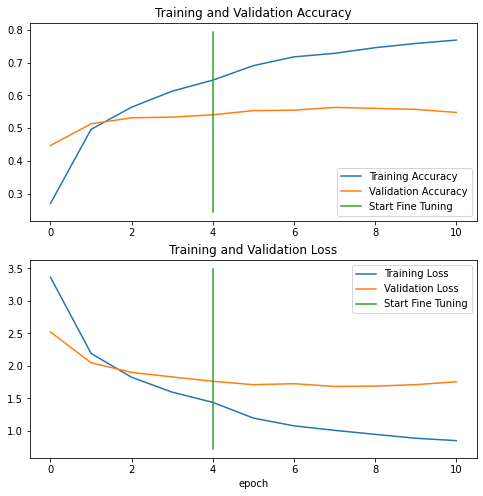

In [19]:
compare_historys(history_0, history_1)

## Saving a loading a model

In [20]:
# Save model
model.save("big_dog_model.hp5")

TypeError: ignored

In [21]:
loaded_model = tf.keras.models.load_model("big_dog_model")

OSError: ignored

In [22]:
# Evaluate loadade model and compare performance
loaded_model.evaluate(test_data)

NameError: ignored

# Evaluating the performance of the big dog model

In [23]:
# Download pre-trained model
import tensorflow as tf


!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

--2023-02-21 23:25:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  21.5MB/s    in 2.1s    

2023-02-21 23:25:45 (21.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [24]:
# Load pre-trained model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [25]:
# Evaluate loaded model
model.evaluate(test_data)

790/790 [==============================] - 68s 84ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

# Making prediction with out trained model

In [26]:
preds_prob = model.predict(test_data, verbose=1)

790/790 [==============================] - 67s 82ms/step


In [27]:
preds_prob[:10]

array([[5.9542067e-02, 3.5742048e-06, 4.1376896e-02, ..., 1.4138652e-09,
        8.3530831e-05, 3.0897569e-03],
       [9.6401680e-01, 1.3753220e-09, 8.4780413e-04, ..., 5.4287149e-05,
        7.8362204e-12, 9.8465835e-10],
       [9.5925879e-01, 3.2533680e-05, 1.4866935e-03, ..., 7.1891486e-07,
        5.4397424e-07, 4.0276045e-05],
       ...,
       [4.7313309e-01, 1.2931172e-07, 1.4805557e-03, ..., 5.9750077e-04,
        6.6968969e-05, 2.3469342e-05],
       [4.4571940e-02, 4.7265320e-07, 1.2258494e-01, ..., 6.3498710e-06,
        7.5318612e-06, 3.6778918e-03],
       [7.2438931e-01, 1.9249691e-09, 5.2310974e-05, ..., 1.2291421e-03,
        1.5792678e-09, 9.6395437e-05]], dtype=float32)

In [28]:
preds_prob.shape

(25250, 101)

In [29]:
preds_prob[0]

array([5.95420673e-02, 3.57420481e-06, 4.13768962e-02, 1.06605957e-09,
       8.16142798e-09, 8.66396554e-09, 8.09271967e-07, 8.56525787e-07,
       1.98591097e-05, 8.09776793e-07, 3.17277427e-09, 9.86735472e-07,
       2.85322982e-04, 7.80488951e-10, 7.42300879e-04, 3.89163033e-05,
       6.47404886e-06, 2.49773507e-06, 3.78912046e-05, 2.06783270e-07,
       1.55384078e-05, 8.15071758e-07, 2.62305684e-06, 2.00106854e-07,
       8.38276890e-07, 5.42159296e-06, 3.73909620e-06, 1.31505322e-08,
       2.77615618e-03, 2.80519707e-05, 6.85622836e-10, 2.55749037e-05,
       1.66889440e-04, 7.64072861e-10, 4.04528371e-04, 1.31506841e-08,
       1.79573601e-06, 1.44482851e-06, 2.30628774e-02, 8.24670053e-07,
       8.53658491e-07, 1.71386273e-06, 7.05254342e-06, 1.84020976e-08,
       2.85534270e-07, 7.94834523e-06, 2.06815321e-06, 1.85251878e-07,
       3.36196422e-08, 3.15225829e-04, 1.04109422e-05, 8.54484426e-07,
       8.47418606e-01, 1.05554454e-05, 4.40947048e-07, 3.74042502e-05,
      

In [30]:
len(preds_prob[0])

101

In [31]:
sum(preds_prob[0])

1.000000051688104

In [32]:
tf.argmax(preds_prob[0]), max(preds_prob[0])

(<tf.Tensor: shape=(), dtype=int64, numpy=52>, 0.8474186)

In [33]:
preds_prob[0,52]

0.8474186

In [34]:
test_data.class_names[52]

'gyoza'

In [35]:
# get pred clasess of each label
pred_classes = preds_prob.argmax(axis=1)
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [36]:
# Get test labels
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

len(y_labels)

25250

In [37]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating predrictions

In [38]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

## Creating a confussion matrix

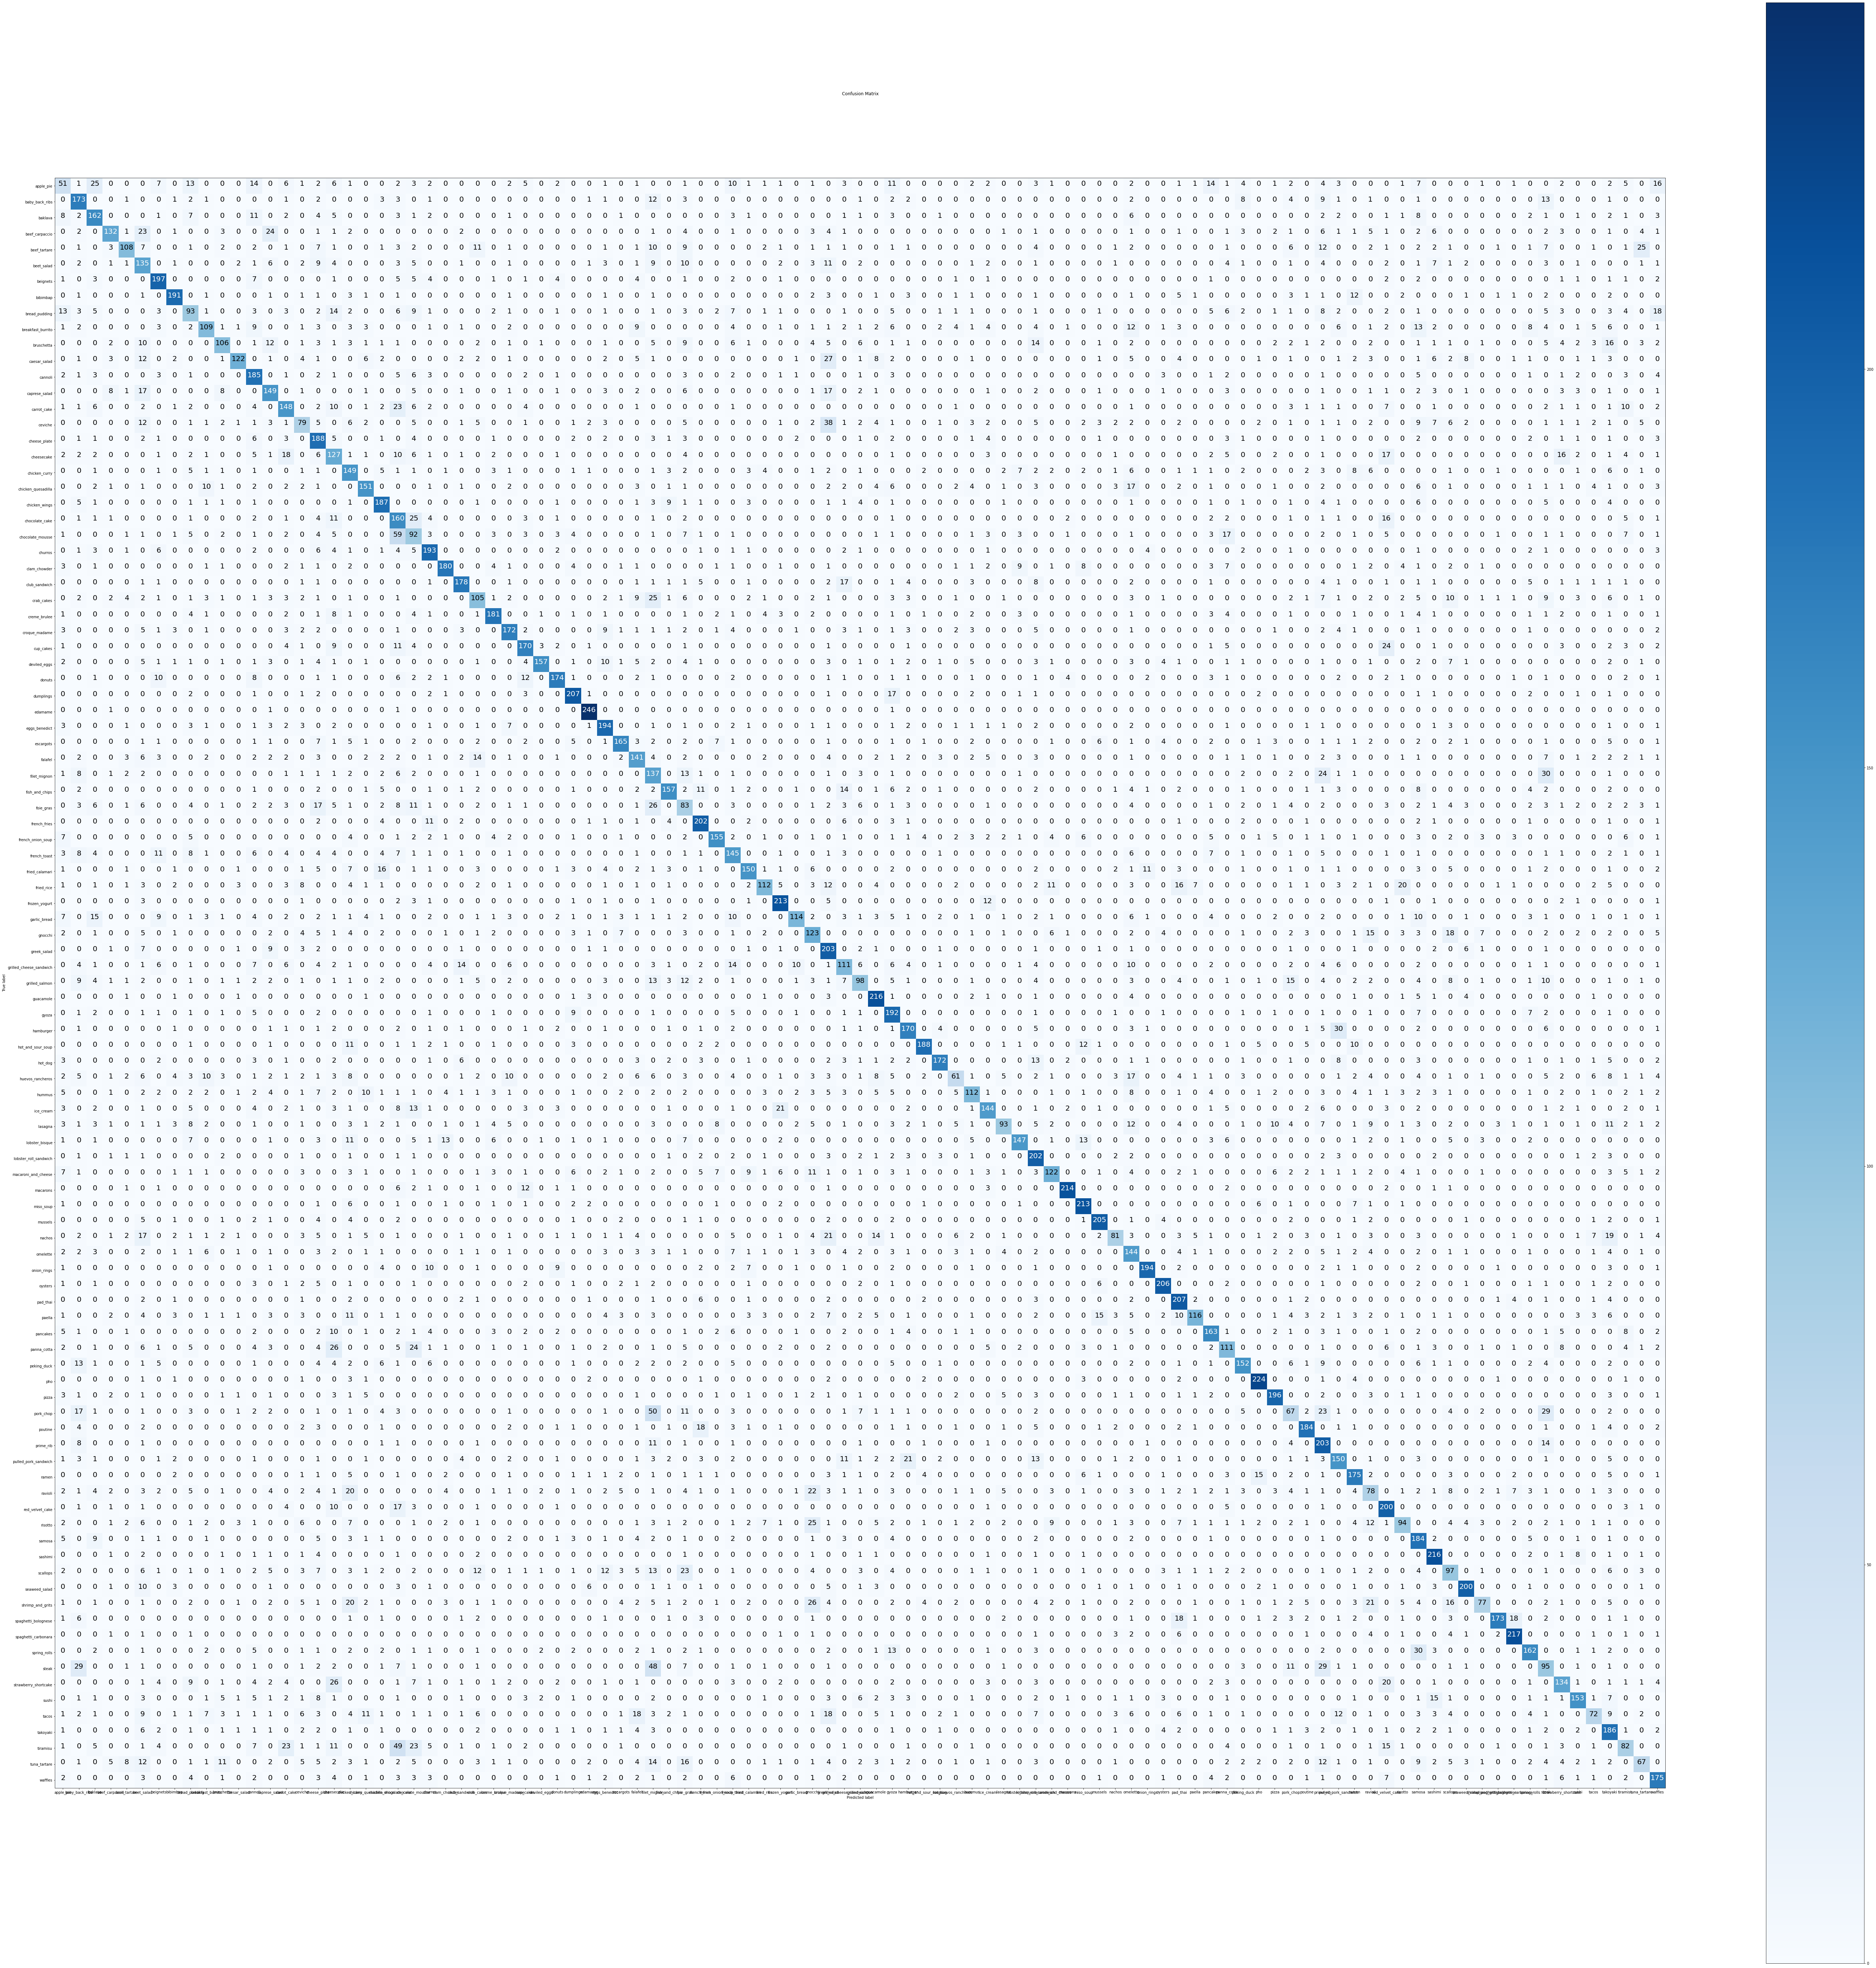

In [39]:
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=test_data.class_names, figsize=(100,100), text_size=20)

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [41]:
# Get a dictionary of classification report

In [42]:
report = classification_report(y_true=y_labels, y_pred=pred_classes, output_dict=True)

In [43]:
report

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [44]:
# Create empty dictionary
class_f1_score = {}

# Loop on report and fill new dictionary
for k, v in report.items():
  if k == "accuracy":
    break
  else:
    class_f1_score[test_data.class_names[int(k)]] = v["f1-score"]

In [45]:
class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [46]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_score.keys()), "f1_score" : list(class_f1_score.values())}).sort_values("f1_score", ascending=False)

In [47]:
f1_scores

,class_name,f1_score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


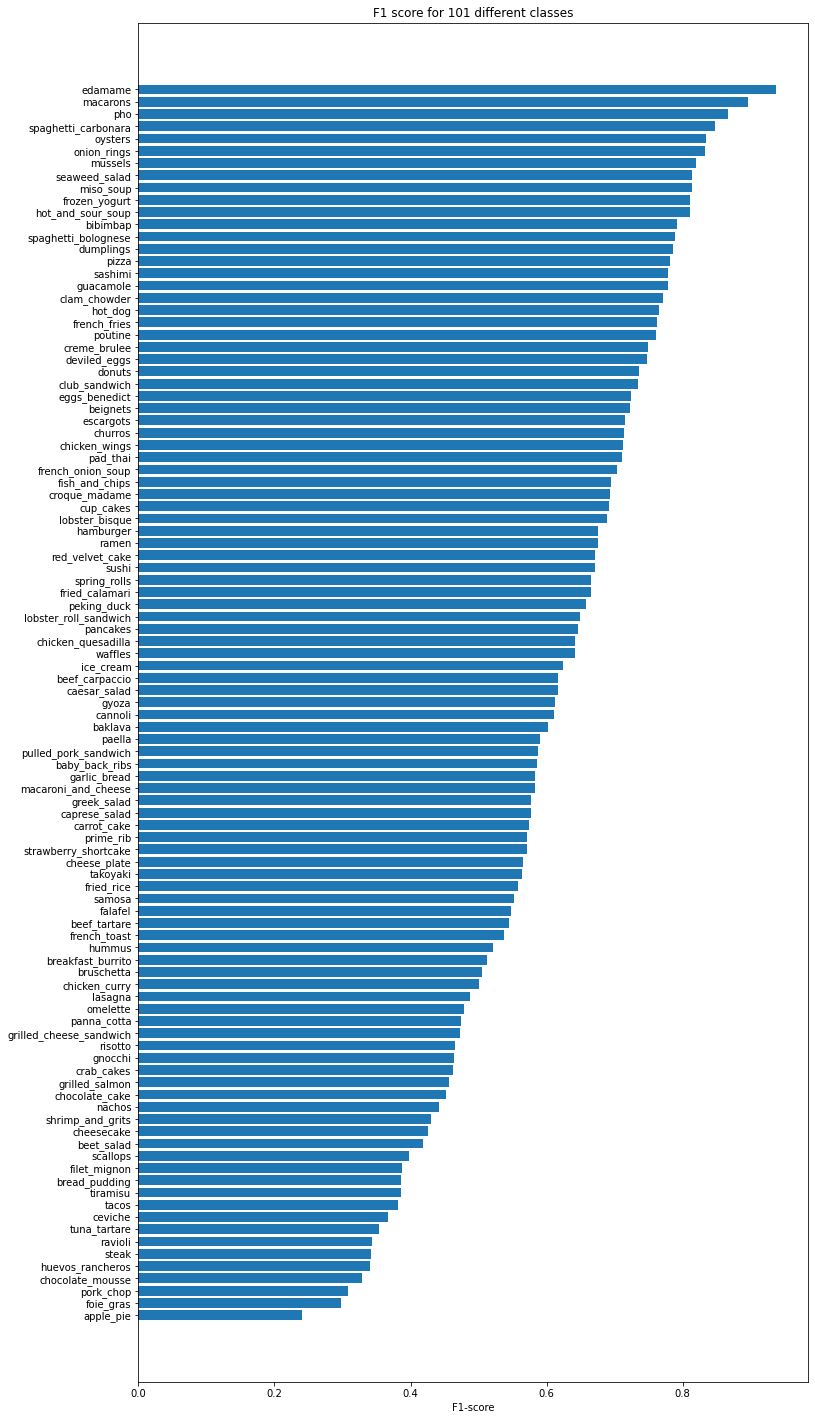

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_name"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 different classes")
ax.invert_yaxis();

# Visualization of predictions
* Read a target image filepath tf.io.read_file()
* Turn the image into a tensor tf.io.decode_image()
* Resize the image (224,224)
* Scale the image (Normalize)

In [49]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns into a tensor and reshape
  
  Args:
    filename (str)
    image_shape (int)
    scale (bool)
  
  Returns:
    tensor
  """
  
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into a tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])

  if scale:
    # Rescale the image(Normalization)
    img = img/255.

  return img
  

1/1 [==============================] - 0s 34ms/step


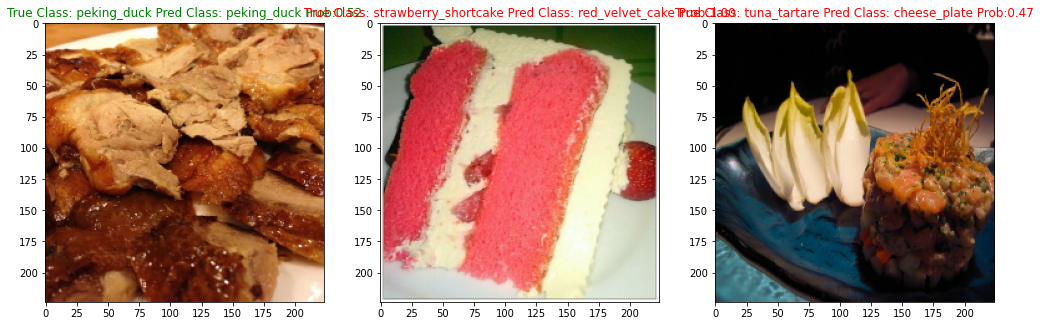

In [50]:
# Make preds on a series of random images

import os
import random

plt.figure(figsize=(17,10))

for i in range(3):
  class_name = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(test_dir + class_name))
  filepath = test_dir + class_name + "/" + filename
  
  img = load_and_prep_image(filepath, scale=False)

  pred_prob = model.predict(tf.expand_dims(img, axis=0));
  pred_class = test_data.class_names[pred_prob.argmax()]

  # Plot images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.);
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  
  plt.title(f"True Class: {class_name} Pred Class: {pred_class} Prob:{pred_prob.max():.2f}", c=title_color)


# Finding the most wrong prediction

1. Get all of the image file path
2. Create a pandas dataframe of image filepath
3. Use our dataframe to find all the wrong predictions
4. Sort the dataframe based on wrong prediction
5. Visualize the images with the higiest prediction probability but have the wron prediction

In [51]:
# Get all file path on imagedataset

filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [52]:
# 2. Create a DataFrame
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_prob.max(axis=1),
                        "y_true_classname": [test_data.class_names[i] for i in y_labels],
                        "y_pred_classname": [test_data.class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.972823,waffles,waffles
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.878028,waffles,cheese_plate
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.537899,waffles,waffles
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.501950,waffles,strawberry_shortcake


In [53]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib,False
...,...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.972823,waffles,waffles,True
25246,b'/content/101_food_classes_10_percent/test/wa...,100,16,0.878028,waffles,cheese_plate,False
25247,b'/content/101_food_classes_10_percent/test/wa...,100,100,0.537899,waffles,waffles,True
25248,b'/content/101_food_classes_10_percent/test/wa...,100,94,0.501950,waffles,strawberry_shortcake,False


In [54]:
# 4. sort our dataframe

top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
8763,b'/content/101_food_classes_10_percent/test/es...,35,41,0.997169,escargots,french_onion_soup,False
2663,b'/content/101_food_classes_10_percent/test/br...,10,61,0.997055,bruschetta,lobster_roll_sandwich,False
7924,b'/content/101_food_classes_10_percent/test/do...,31,29,0.997020,donuts,cup_cakes,False
18586,b'/content/101_food_classes_10_percent/test/pe...,74,39,0.996885,peking_duck,foie_gras,False


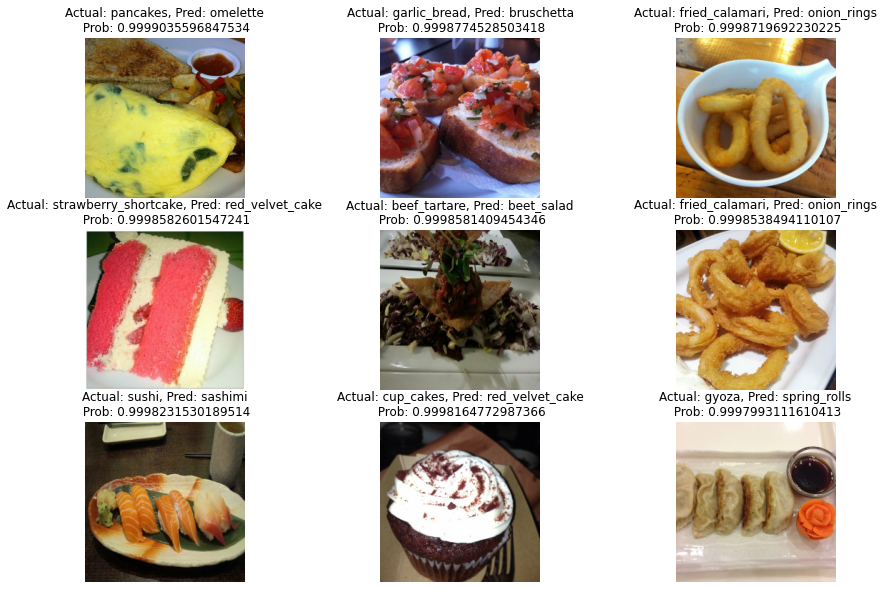

In [55]:
# 5. Visualize the images with wrong prediction and high confidence
images_to_view = 9
start_index = 10

plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_classname}, Pred: {y_pred_classname}\n Prob: {pred_prob}")
  plt.axis(False)

# Test on our custom images

In [56]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2023-02-21 23:29:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.251.31.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  13.6MB/s    in 0.9s    

2023-02-21 23:30:00 (13.6 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [57]:
custom_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 70ms/step


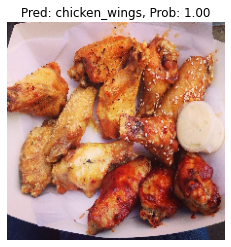

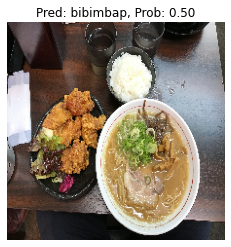

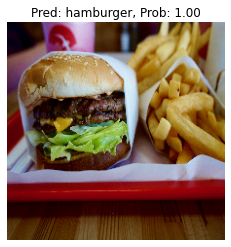

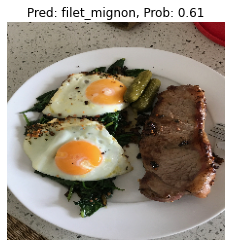

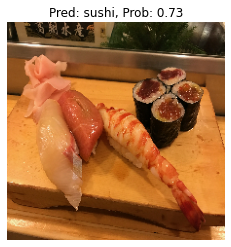

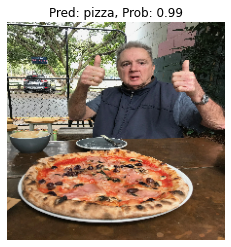

In [58]:
# Make predictions on custom images

for img in custom_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = test_data.class_names[pred_prob.argmax()]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Pred: {pred_class}, Prob: {pred_prob.max():.2f}")
  plt.axis(False)